In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.environ["SCIPY_ARRAY_API"] = "1"


In [3]:
!pip install scanpy
!pip install --upgrade scipy scikit-learn celltypist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 98.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 159.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 130.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 116.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 134.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


# MoRE


In [6]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/me/MoRE')

from MoRE_model import MoRE

In [7]:
# ---------- Training Loop ----------
def train(model, data_tensor, label_tensor, batch_tensor, epochs=10, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_history = []

    for epoch in range(epochs):
        model.train()
        inputs = [data_tensor, data_tensor]  # same modality twice for simplicity
        logits, refined, embeddings, losses = model(inputs, labels=label_tensor, batch_labels=batch_tensor)

        optimizer.zero_grad()
        losses['total'].backward()
        optimizer.step()

        print(f"Epoch {epoch+1}/{epochs} - Loss: {losses['total'].item():.4f}")
        loss_history.append(losses['total'].item())

    return loss_history

# Inference + UMAP Visualization + Confusion Matrix

<Figure size 20000x6000 with 0 Axes>

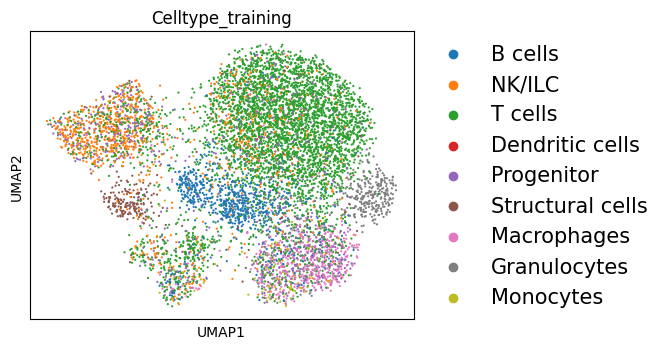

<Figure size 6000x1000 with 0 Axes>

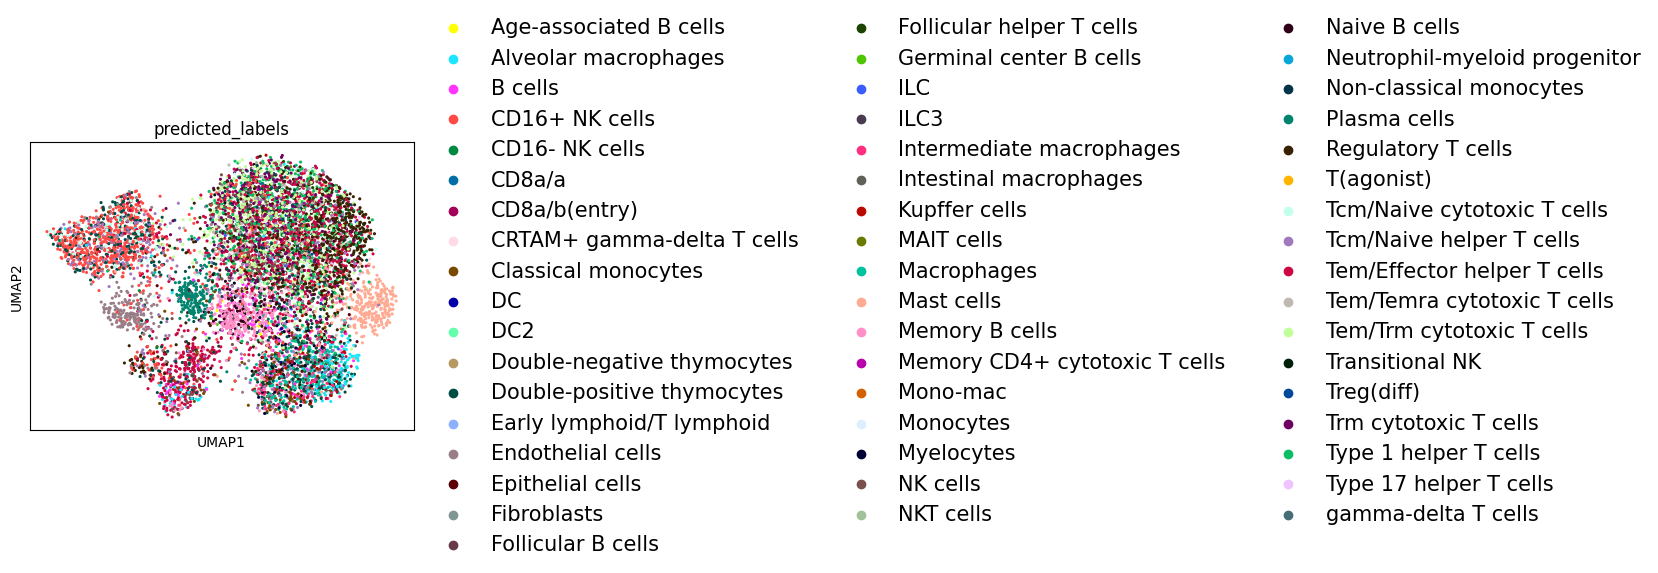

<Figure size 6000x1000 with 0 Axes>

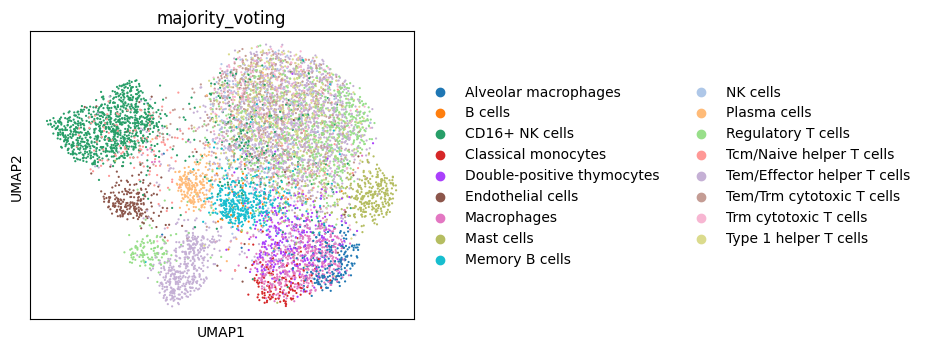

<Figure size 6000x1000 with 0 Axes>

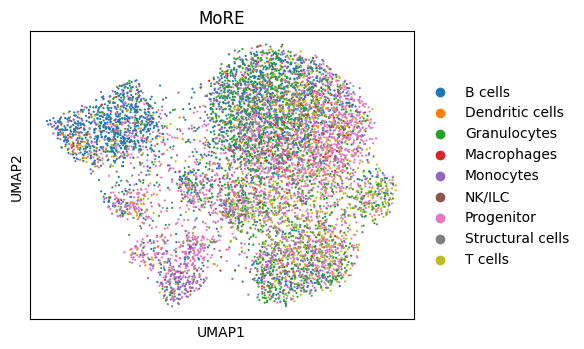

In [9]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import os

# ---------- Device & Save Directory ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_dir = '/content/drive/MyDrive/Colab Notebooks/me/MoRE/figures'
os.makedirs(save_dir, exist_ok=True)

# ---------- Load Data ----------
adata = sc.read_h5ad('/content/drive/MyDrive/Colab Notebooks/me/MoRE/GSE153935_annotate.h5ad')
X = adata.X.toarray() if not isinstance(adata.X, np.ndarray) else adata.X
data_tensor = torch.tensor(X, dtype=torch.float32).to(device)

# ---------- Encode Labels ----------
label_encoder = LabelEncoder()
y_true = label_encoder.fit_transform(adata.obs["Celltype_training"])
num_classes = len(label_encoder.classes_)
from sklearn.preprocessing import LabelEncoder
batch_encoder = LabelEncoder()
batch_indices = batch_encoder.fit_transform(adata.obs["sample_id"])
batch_tensor = torch.tensor(batch_indices, dtype=torch.long).to(device)

n_batches = len(batch_encoder.classes_)
# ---------- Initialize Model ----------
input_dim = data_tensor.shape[1]
model = MoRE(
    input_dims=[input_dim, input_dim],
    embed_dim=128,
    num_classes=num_classes,
    n_batches=n_batches
).to(device)

# ---------- Inference ----------
with torch.no_grad():
    logits, refined_embedding, modality_embeds, losses = model([data_tensor, data_tensor])
    probs = torch.softmax(logits, dim=1)
    y_pred = torch.argmax(probs, dim=1).cpu().numpy()
    embeddings = refined_embedding.cpu().numpy()

# ---------- Save Results ----------
adata.obsm["X_more"] = embeddings
adata.obs["MoRE"] = label_encoder.inverse_transform(y_pred)

# ---------- Use refined embedding directly ----------
adata.obsm["X_umap"] = refined_embedding.cpu().numpy()

sc.pp.neighbors(adata, use_rep="X_umap")
sc.tl.umap(adata)

# ---------- UMAP Visualization ----------
plt.figure(figsize=(200, 60))
sc.pl.umap(adata, color=['Celltype_training'], size=10, legend_fontsize=15, legend_fontoutline=0, legend_loc='right margin', show=False)
plt.subplots_adjust(left=0.1, right=0.7, top=0.8, bottom=0.2)
plt.savefig(os.path.join(save_dir,"Celltype_training.svg"), format='svg', dpi=300, bbox_inches=None)

plt.figure(figsize=(60, 10))
sc.pl.umap(adata, color=['predicted_labels'], size=20, legend_fontsize=15, legend_fontoutline=0, legend_loc='right margin', show=False)
plt.subplots_adjust(left=0.1, right=0.7, top=0.8, bottom=0.2)
plt.savefig(os.path.join(save_dir,"predicted_labels.svg"), format='svg', dpi=300, bbox_inches=None)

plt.figure(figsize=(60, 10))
sc.pl.umap(adata, color=['majority_voting'], size=10, legend_fontsize=10, legend_fontoutline=0, legend_loc='right margin', show=False)
plt.subplots_adjust(left=0.1, right=0.7, top=0.8, bottom=0.2)
plt.savefig(os.path.join(save_dir,"majority_voting.svg"), format='svg', dpi=300, bbox_inches=None)
sc.pp.neighbors(adata, use_rep="X_more")
sc.tl.umap(adata)

plt.figure(figsize=(60, 10))
sc.pl.umap(adata, color=['MoRE'], size=10, legend_fontsize=10, legend_fontoutline=0, legend_loc='right margin', show=False)
plt.subplots_adjust(left=0.1, right=0.7, top=0.8, bottom=0.2)
plt.savefig(os.path.join(save_dir,"MoRE.svg"), format='svg', dpi=300, bbox_inches=None)
sc.pp.neighbors(adata, use_rep="X_more")
sc.tl.umap(adata)
